In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
def NODES(_X,_xi,_yi,_xf,_yf):
    m,n = _X.shape
    nodes = np.copy(_X)
    nodes = nodes.reshape(2,n//2).T
    nodes = np.concatenate(([[xi,yi]],nodes),axis=0)
    nodes = np.concatenate((nodes,[[xf,yf]]),axis=0)
    return nodes.T[0],nodes.T[1]

In [3]:
def f(_X):
    global yi,yf,Length
    m,n = _X.shape
    temp_L=0.5*(Length[0,:-1]+Length[0,1:])
    F=np.dot(temp_L,_X[0,n//2:].T)+Length[0,0]*yi/2+Length[0,-1]*yf/2
    return F
def g(_X):
    global yi,yf,Length,nb,nj
    m,n = _X.shape
    temp_dy=0.5*(Length[0,:-1]+Length[0,1:])
    G = np.concatenate((np.zeros(shape=(1,n//2)),temp_dy),axis=None)
    return G.reshape(1,2*nj)

In [4]:
def h(_X):
    global xi,yi,xf,yf,Length
    m,n = _X.shape
    nodes = np.copy(_X)
    nodes = nodes.reshape(2,n//2).T
    nodes = np.concatenate(([[xi,yi]],nodes),axis=0)
    nodes = np.concatenate((nodes,[[xf,yf]]),axis=0)
    li = np.linalg.norm((nodes[1:]-nodes[:-1]),axis=1)
    H = (li**2 - Length**2).T
    return H
def Jh(_X):
    global xi,yi,xf,yf,Length
    m , n = _X.shape
    nj = n//2
    nodes = np.copy(_X)
    nodes = nodes.reshape(2,nj).T
    nodes = np.concatenate(([[xi,yi]],nodes),axis=0)
    nodes = np.concatenate((nodes,[[xf,yf]]),axis=0)
    delta = (nodes[1:]-nodes[:-1])
    jx = 2*np.concatenate((np.eye(nj),np.zeros(shape=(1,nj))),axis=0) - 2*np.concatenate((np.zeros(shape=(1,nj)),np.eye(nj)),axis=0)
    dJ = np.concatenate((jx,jx),axis=1)
    JH = np.multiply(np.repeat(delta, repeats=nj,axis=1),dJ)
    return JH

In [5]:
def phi(_X, Lamda, C):
    H,J = oracleH(_X, mode=1)
    F,G = oracleF(_X, mode=1)
    L = F + np.dot(Lamda,H)+C/2*np.linalg.norm(H)**2
    return L
def Gphi( _X, Lamda, C):
    H,J = oracleH(_X, mode=2)
    F,G = oracleF(_X, mode=2)
    GL = G.T + np.dot(J.T,Lamda.T) + C*np.dot(J.T,H)
    return GL

In [6]:
def Lagrange( _X, Lamda, C):
    H,J = oracleH(_X, mode=1)
    F,G = oracleF(_X, mode=1)
    L = F + np.dot(Lamda,H)+C/2*np.linalg.norm(H)**2
    return L
def DLagrange( _X, Lamda, C):
    H,J = oracleH(_X, mode=2)
    F,G = oracleF(_X, mode=2)
    GL = np.concatenate((G.T + np.dot(J.T,Lamda.T) + C*np.dot(J.T,H), H), axis=None)
    return GL

In [7]:
def oracleF(X, mode):
    if mode==1:
        return f(X),None 
    elif mode==2:
        return f(X),g(X)
    elif mode==3:
        return None,g(X)
    else:
        print('Not on the list')  
        
def oracleH(X, mode):
    if mode==1:
        return h(X),None 
    elif mode==2:
        return h(X),Jh(X)
    elif mode==3:
        return None,Jh(X)
    else:
        print('Not on the list') 
        
def oraclePhi(X,Lamda,C, mode):
    if mode==1:
        return phi(X,Lamda,C),None 
    elif mode==2:
        return phi(X,Lamda,C),Gphi(X,Lamda,C)
    elif mode==3:
        return None,Gphi(X,Lamda,C)
    else:
        print('Not on the list')  
        
def oracleL(X,Lamda,C, mode):
    if mode==1:
        return Lagrange(X,Lamda,C),None 
    elif mode==2:
        return Lagrange(X,Lamda,C),DLagrange(X,Lamda,C)
    elif mode==3:
        return None,DLagrange(X,Lamda,C)
    else:
        print('Not on the list')  

In [8]:
def Armijo(Xk,lamdak,ck,d,MaxItLineSearch,t0 = 100, theta=0.2, m=0.001):
    p=0
    t = [t0]
    while True:
        phi, gphi = oraclePhi(Xk,lamdak,ck, mode=2)
        phi1, gphi1 = oraclePhi(Xk+t[-1]*d.T,lamdak,ck, mode=1)
        
        if phi1 <= phi + m*t[-1]*np.dot(gphi.T,d):
            return t[-1]
        else:
            t.append(theta*t[-1])
            if p<MaxItLineSearch:
                p+=1
            else:
                print(f'Max iterations \n\t direction: {d} \n\t step:{t[-1]}')
                raise ValueError('Max iteration')

            
def MinPhi(xk_0, lamdak, ck,MaxIt=1000,tol = 10e-6, MaxItLineSearch=50, step = 100):
    k=0
    Xk =  [xk_0] 
    while True:
        phi, gphi = oraclePhi(Xk[-1],lamdak,ck, mode=2)
        if np.linalg.norm(gphi)<tol:
#            print (f'Converged on {Xk[-1]}')
            return Xk[-1],Xk
        else:
            d = -1*gphi
            step = Armijo(Xk[-1],lamdak,ck,d, MaxItLineSearch=MaxItLineSearch, t0 = 100)                          
            Xk.append(Xk[-1] + step*d.T)
            if k<MaxIt:
                k+=1
            else:
                print('Max iterations')
                return None,Xk

def algorithm(x0,lamda0,c0, tol = 10e-6, MaxIt=1000, stepC=0.1):
    k=0
    C = [c0]
    Lamda = [lamda0]
    Xk =  [x0] 
    Xkh = []
    while True:
        Xkh.append([])
        Xk[-1],Xkh[-1] = MinPhi(Xk[-1],Lamda[-1],C[-1])
        lagrange, gradient = oracleL(Xk[-1],Lamda[-1],C[-1], mode = 2)
        if np.linalg.norm(gradient)<tol:
            print (f'Converged on {Xk[-1]}')
            return Xk[-1],Lamda[-1],C[-1], Xk
        else:
            hk,jk = oracleH(Xk[-1], mode=1)
            Lamda.append(Lamda[-1]+C[-1]*hk.T)
            C.append(C[-1]+stepC)
            if k<MaxIt:
                k+=1
            else:
                print('Max iterations algo1')
                return None,Xk,None,Lamda,None,C

In [9]:
%matplotlib inline
def plotchain(a,x0, xi,yi,xf,yf):
    XiPoints,YiPoints = NODES(x0, xi,yi,xf,yf)
    XPoints,YPoints = NODES(a, xi,yi,xf,yf)
    print(XPoints,YPoints)
    plt.plot(XiPoints,YiPoints, linestyle='--', marker='o')
    plt.plot(XPoints,YPoints, marker='o')

    for i_x, i_y in zip(XPoints,YPoints):
        plt.text(i_x, i_y, '(%.2f,%.2f)'%(i_x,i_y))
    

Converged on [[ 2.99999974  8.00000023 -4.00000068 -4.00000066]]
[ 0.          2.99999974  8.00000023 11.        ] [ 0.         -4.00000068 -4.00000066  0.        ]


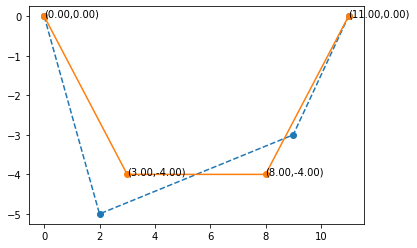

In [10]:
xi=0
yi=0
xf=11
yf=0
nb=3
nj=nb-1
Length = np.ones(shape=(1,nb))*5
x0 = np.array([[2,9,-5,-3]])
lamda0 = np.zeros(shape=(1,nb))
c0=0.1

a,b,c, it = algorithm(x0,lamda0,c0)

plotchain(a,x0, xi,yi,xf,yf)

Converged on [[ 0.15339183  0.33946835  0.5742395   0.76186021 -0.36942036 -0.6047385
  -0.69066454 -0.62138621]]
[0.         0.15339183 0.33946835 0.5742395  0.76186021 1.        ] [ 0.         -0.36942036 -0.6047385  -0.69066454 -0.62138621 -0.3       ]


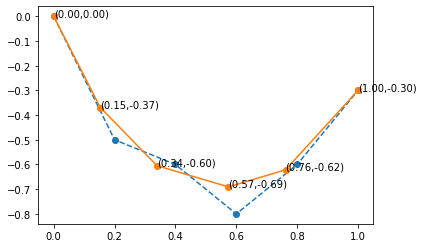

In [11]:
xi=0
yi=0
xf=1
yf=-0.3
nb=5
nj=nb-1
Length = np.array([[0.4,0.3,0.25,0.2,0.4]])
x0 = np.array([[0.2,0.4,0.6,0.8,-0.5,-0.6,-0.8,-0.6]])
lamda0 = np.zeros(shape=(1,nb))
c0=1

a,b,c, it = algorithm(x0,lamda0,c0)
plotchain(a,x0, xi,yi,xf,yf)

Converged on [[ 0.15339183  0.33946835  0.5742395   0.76186021 -0.36942036 -0.6047385
  -0.69066454 -0.62138621]]
[0.         0.15339183 0.33946835 0.5742395  0.76186021 1.        ] [ 0.         -0.36942036 -0.6047385  -0.69066454 -0.62138621 -0.3       ]


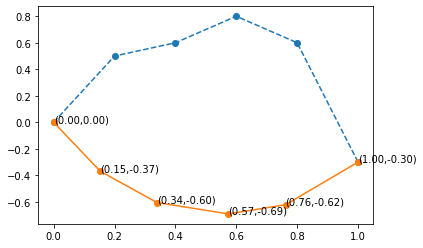

In [12]:
xi=0
yi=0
xf=1
yf=-0.3
nb=5
nj=nb-1
Length = np.array([[0.4,0.3,0.25,0.2,0.4]])
x0 = np.array([[0.2,0.4,0.6,0.8,0.5,0.6,0.8,0.6]])
lamda0 = np.zeros(shape=(1,nb))
c0=1

a,b,c, it = algorithm(x0,lamda0,c0)
plotchain(a,x0, xi,yi,xf,yf)

Converged on [[ 0.10364362  0.24138974  0.46264052  0.63214398 -0.38634018 -0.65284693
  -0.76925186 -0.66307754]]
[0.         0.10364362 0.24138974 0.46264052 0.63214398 0.8       ] [ 0.         -0.38634018 -0.65284693 -0.76925186 -0.66307754 -0.3       ]


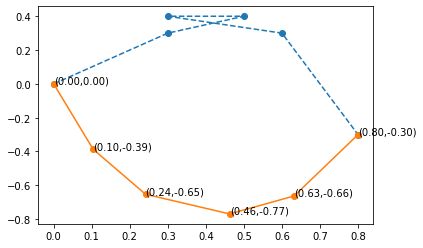

In [13]:
xi=0
yi=0
xf=0.8
yf=-0.3
nb=5
nj=nb-1
Length = np.array([[0.4,0.3,0.25,0.2,0.4]])
x0 = np.array([[0.3,0.5,0.3,0.6,0.3,0.4,0.4,0.3]])
lamda0 = np.zeros(shape=(1,nb))
c0=1

a,b,c, it = algorithm(x0,lamda0,c0)
plotchain(a,x0, xi,yi,xf,yf)